In [110]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.optimize as sop
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

mosprime3m = pd.read_csv('mosprime3m.csv',header=None,
                         index_col=0, names=['r3m'])['r3m'].sort_index()
mosprime3m_between = pd.read_csv('mosprime3m_between.csv', header=None,
                                 index_col=0, names=['r3m'])['r3m'].sort_index()
mosprime3m_short = pd.read_csv('mosprime3m_short.csv', header=None,
                               index_col=0, names=['r3m'])['r3m'].sort_index()

In [111]:
def HW1_path(r0, days, l, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    l = l # лямбда
    a = a # альфа 
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = r[t - 1] +  (l - a *r[t - 1])*dt + vol * rand[t] * np.sqrt(dt)
    HW1 = pd.DataFrame(r[:, 0], columns=['index'])
    HW1 = HW1.values.flatten()
    return HW1

def HW1_p_cst(data, opt, num_paths=10, alpha=0.7, title='Calibrated HW1 Short Rate Simulation'):
    for i in range(num_paths):
        plt.plot(HW1_path(data[0], len(data), opt[0], opt[1],
                      opt[2]), lw=0.8, alpha=alpha)
    plt.title(title)
    plt.plot(data, label = 'data')
    plt.legend()
    plt.tight_layout
    plt.show()
       
def HW1_ml_final_diff_cst(p0, penalty=np.inf):
    theta, a, vol = p0
    if vol < 0.0:
        return penalty 
    x = data
    dx = np.diff(data)
    dt = np.array([1/252]*len(dx))
    sigma1 = vol * np.sqrt((1-np.exp(-2 * a * dt))/(2 * a))
    sigma = np.sqrt (vol ** 2 * dt + (sigma1 * a * dt) ** 2) 
    mu1 = data[:-1] * np.exp(-a * dt) + (theta / a) * (1 - np.exp(-a * dt)) 
    mu = (theta - a * mu1)*dt
    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

def HW1_ml_final_diff_cst2(p0, penalty=np.inf):
    theta, a, vol = p0
    if vol < 0.0:
        return penalty 
    x = data
    dx = np.diff(data)
    dt = np.array([1/252]*len(dx))
    sigma = vol*np.sqrt(dt) 
    mu = (theta - a * x[:-1])*dt
    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

def HW1_ml_final_len1(p0, penalty=np.inf):
    b = 0
    l, a, vol = p0
    if vol < 0.0 or a < 0 or l < 0:
        return penalty 
    x = data[1:]
    t = np.array([1/252]*len(x))
    sigma = vol * np.sqrt((1-np.exp(-2 * a * t))/(2 * a))
    mu = data[:-1] * np.exp(-a * t) + (l/a)*(1 - np.exp(2*a * t))
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

def HW1_ml_final(p0, penalty=np.inf):
    l, a, vol = p0
    if vol < 0.0 or a < 0 or l < 0:
        return penalty 
    x = data
    t = (np.array(list(range(len(data)))) + 1)/252
    sigma = vol * np.sqrt((1-np.exp(-2 * a * t))/(2 * a))
    mu = min(data) * np.exp(-a * t) + np.exp(-a * t)*(l)*(1 + np.exp(a * t)*(-1 + a * t))/(a**2)
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [112]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def C0_ecdf_dist(f1, f2):
    xs1, ys1 = ecdf(f1)
    xs, ys = ecdf(f2)
    minv = np.minimum(xs1[0], xs[0]) - 0.001
    maxv = np.maximum(xs1[-1], xs[-1]) + 0.001

    xs = np.insert(xs, 0, minv)
    xs1 =  np.insert(xs1, 0 , minv)
    xs1 = np.insert(xs1, len(xs1), maxv)
    xs = np.insert(xs, len(xs), maxv)

    ys = np.insert(ys, 0, 0)
    ys = np.insert(ys, len(ys)-1, 1)
    ys1 = np.insert(ys1, 0, 0)
    ys1 = np.insert(ys1, len(ys)-1, 1)
    f = np.zeros(len(xs1))
    for i in range(len(xs1)):
        if xs[i] == xs1[i]:
            f[i] = np.abs(ys1[i]-ys[i])
        else: 
            temp = xs1[i] <xs
            f[i] = np.abs(ys1[i] - ys[temp.argmax()-1])
    return np.max(f)

def mean_C0(opt, n_path=100):
    t = []
    for i in range(n_path):
        t.append(C0_ecdf_dist(data, HW1_path(data[0], len(data), opt[0], opt[1], opt[2])))
    return np.mean(t)

def mean_max_dist(opt, data, num_paths):
    dist = []
    for i in range(num_paths):
        dist.append(np.max(np.abs(data - HW1_path(data[0], len(data), opt[0], opt[1], opt[2]))))
    return np.mean(dist)

In [113]:
data = mosprime3m_short

In [147]:
data_gen = HW1_path(r0=6, days=100000, l=6.4, a=0.7, vol=0.3)
data_gen = pd.DataFrame(data_gen, index=pd.date_range(start=1, periods=100000, freq='D'))
data = data_gen.values.flatten()
x = data
median = np.median(x)
mean = np.mean(x)
std = np.std(x)
p4 = [median, np.max(x)-np.min(x), std]#db252_HW1.values[i,:3]
p1 = np.array([0.01, 0.01, 0.01])
p2 = np.array([0.1,  0.1, 0.1])
p3 = np.array([40, 2, 1])

In [148]:
p4

[9.118830007987302, 4.078763378959433, 0.2749422778003593]

theta0: 6.4, a0: 0.7, vol0: 0.3, theta0/a0 : 9.142857142857144
theta: 37.14051581232471, a: 4.072859296399866, vol: 0.30576584932308953, theta/a : 9.119027471721017
Среднее максимальное расстояние между траекториями:  1.7373081998572188
Среднее С0 расстояние между функциями распределения: 0.19851999999999997


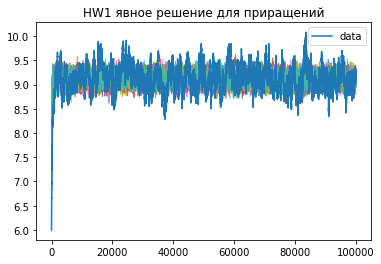

In [149]:
HW = sop.minimize(HW1_ml_final_diff_cst, p4, method='Powell').x

print("theta0: {theta}, a0: {a}, vol0: {vol}, theta0/a0 : {ta}".format(theta = 6.4, a = 0.7, vol = 0.3, ta = 6.4/0.7))
print("theta: {theta}, a: {a}, vol: {vol}, theta/a : {ta}".format(theta = HW[0], a = HW[1], vol = HW[2], ta=HW[0]/HW[1]))
print('Среднее максимальное расстояние между траекториями: ',mean_max_dist(HW, data, num_paths=10))
print('Среднее С0 расстояние между функциями распределения:' , mean_C0(HW, n_path=10))
HW1_p_cst(data, HW, num_paths=10, title='HW1 явное решение для приращений')

theta0: 6.4, a0: 0.7, vol0: 0.3, theta0/a0 : 9.142857142857144
theta: 37.13934829097168, a: 4.072748831080465, vol: 0.30601464591951305, theta/a : 9.118988140773448
Среднее максимальное расстояние между траекториями:  1.7435651765024318
Среднее С0 расстояние между функциями распределения: 0.199971


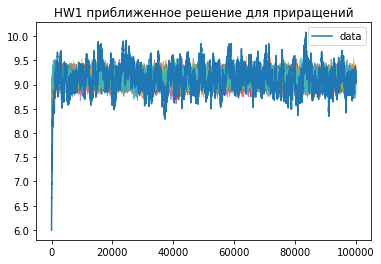

In [150]:
HW = sop.minimize(HW1_ml_final_diff_cst2, p4, method='Powell').x

print("theta0: {theta}, a0: {a}, vol0: {vol}, theta0/a0 : {ta}".format(theta = 6.4, a = 0.7, vol = 0.3, ta = 6.4/0.7))
print("theta: {theta}, a: {a}, vol: {vol}, theta/a : {ta}".format(theta = HW[0], a = HW[1], vol = HW[2], ta=HW[0]/HW[1]))
print('Среднее максимальное расстояние между траекториями: ',mean_max_dist(HW, data, num_paths=10))
print('Среднее С0 расстояние между функциями распределения:' , mean_C0(HW, n_path=10))
HW1_p_cst(data, HW, num_paths=10, title='HW1 приближенное решение для приращений')

In [151]:
def rolling_HW1_cst_df(db=mosprime3m, func=HW1_ml_final_diff_cst2,  periods=252):
    date_start_end = (pd.date_range(end = db.index.min(), periods=1, freq='d') + periods - 1).strftime('%Y-%m-%d')[0]
    #end_dates = pd.date_range(start=date_start_end, end = db.index.max(), freq='d').strftime('%Y-%m-%d')
    #end_dates = [i for i in end_dates if i in db.index]
    df_cal_HW1_cst = pd.DataFrame(columns=["theta", "alpha", "vol", "mean", "std"], index=np.array(db.index[periods:]))
    for i in tqdm(range(len(df_cal_HW1_cst))):
        global data
        data = db.dropna().values[i:(periods+i)]
        x = data
        mean = np.mean(x)
        std = np.std(x)
        p4 = [mean, np.max(x)-np.min(x), std]#db252_HW1.values[i,:3]
        par = sop.minimize(func, p4, method='Powell').x
        df_cal_HW1_cst.iloc[i] = np.append(par, [mean, std])
    return df_cal_HW1_cst

In [152]:
db252_HW1_df = rolling_HW1_cst_df(db=data_gen[0], periods=252)

100%|██████████| 99748/99748 [25:52<00:00, 64.25it/s]


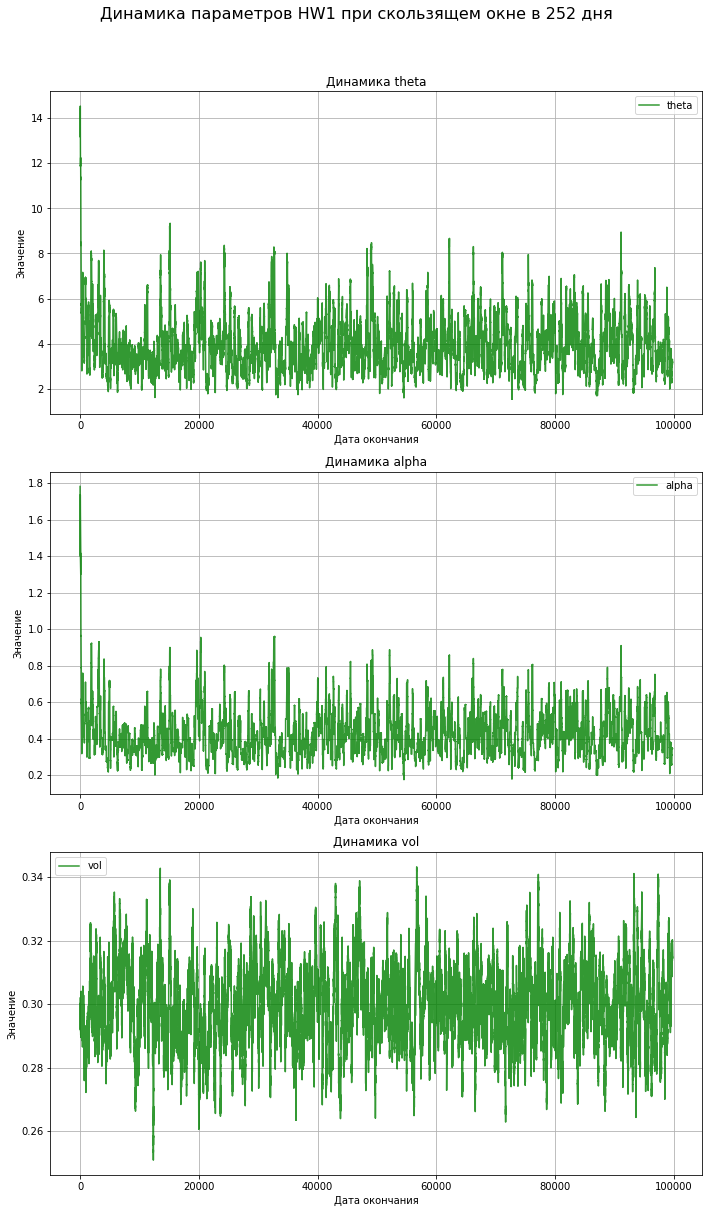

In [153]:
plt.figure(figsize=[10,16])
plt.subplot(3,1,1)
plt.plot(db252_HW1_df['theta'].values , 'g-',  alpha = 0.8, label = 'theta')
plt.title('Динамика theta')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
#plt.ylim([-10,10])
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot(db252_HW1_df['alpha'].values , 'g-',  alpha = 0.8, label = 'alpha')
plt.title('Динамика alpha')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.subplot(3,1,3)
plt.plot(db252_HW1_df['vol'].values , 'g-',  alpha = 0.8, label = 'vol')
plt.title('Динамика vol')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()


plt.suptitle('Динамика параметров HW1 при скользящем окне в 252 дня' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

In [154]:
a = np.array(db252_HW1_df['alpha'].values, dtype=float)
l = np.array(db252_HW1_df['theta'].values, dtype=float)
vol = np.array(db252_HW1_df['vol'].values, dtype=float)
b = np.zeros(len(a))

In [155]:
x = data_gen[0].values[:-252]
t252 = np.array([252/252]*len(a))
sigma252 = vol * np.sqrt((1-np.exp(-2 * a * t252))/(2 * a))
mu252 = x * np.exp(-a * t252) + np.exp(-a * t252)*(l + b * t252)*(1 + np.exp(a * t252)*(-1 + a * t252))/(a**2)
t1 = np.array([1/252]*len(a))
sigma1 = vol * np.sqrt((1-np.exp(-2 * a * t1))/(2 * a))
mu1 = x * np.exp(-a * t1) + np.exp(-a * t1)*(l + b * t1)*(1 + np.exp(a * t1)*(-1 + a * t1))/(a**2)
t21 = np.array([21/252]*len(a))
sigma21 = vol * np.sqrt((1-np.exp(-2 * a * t21))/(2 * a))
mu21 = x * np.exp(-a * t21) + np.exp(-a * t21)*(l + b * t21)*(1 + np.exp(a * t21)*(-1 + a * t21))/(a**2)

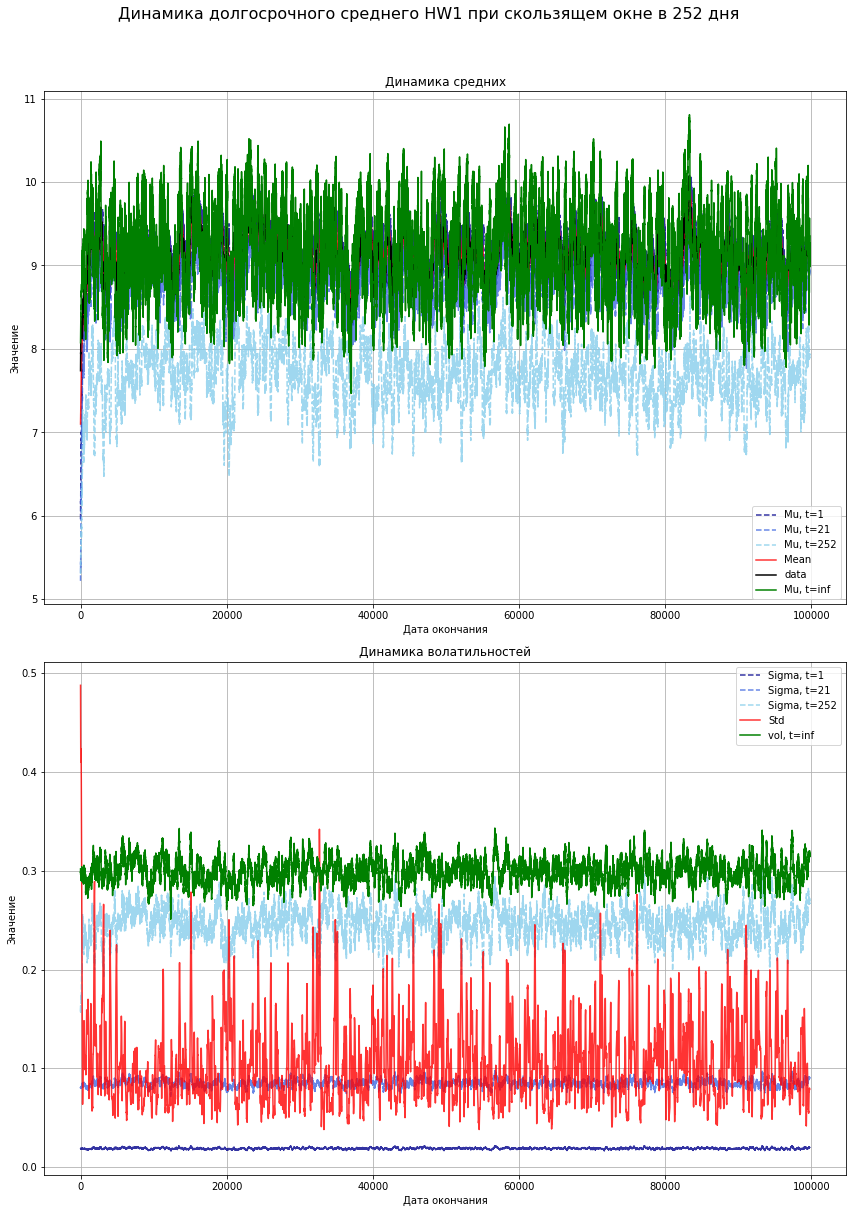

In [156]:
plt.figure(figsize=[12,16])

plt.subplot(2,1,1)
plt.plot(mu1 , '--', color='darkblue',  alpha = 0.8, label = 'Mu, t=1')
plt.plot(mu21 , '--', color='royalblue',  alpha = 0.8, label = 'Mu, t=21')
plt.plot(mu252 , '--', color='skyblue',  alpha = 0.8, label = 'Mu, t=252')
plt.plot(db252_HW1_df['mean'].values , 'r-',  alpha = 0.8, label = 'Mean')
plt.plot(data_gen[0].values[252:] , 'black', label = 'data')
plt.plot(l/a , 'g-',  alpha = 1, label = 'Mu, t=inf')
plt.title('Динамика средних')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(sigma1 , '--', color='darkblue',  alpha = 0.8, label = 'Sigma, t=1')
plt.plot(sigma21 , '--', color='royalblue',  alpha = 0.8, label = 'Sigma, t=21')
plt.plot(sigma252 ,'--', color='skyblue',  alpha = 0.8, label = 'Sigma, t=252')
plt.plot(db252_HW1_df['std'].values , 'r-',  alpha = 0.8, label = 'Std')
plt.plot(db252_HW1_df['vol'].values , 'g-',  alpha = 1, label = 'vol, t=inf')
plt.title('Динамика волатильностей')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.suptitle('Динамика долгосрочного среднего HW1 при скользящем окне в 252 дня' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()